### Segmentation 02 

- Testing 2D segmentation class implementation

In [45]:
%run ../utils.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from cytokit.segmentation import segmenter
from skimage import feature
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import exposure
from scipy import ndimage

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# best_z = 21
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]

exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle')
exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
#exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-tf-dynamic-psf', '2-Deconvolution')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 2
mem_ch = 1
best_z = 4
crop = [slice(0, 512), slice(0, 512)]
# #crop = [slice(None, None), slice(None, None)]

model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [46]:
exp_conf = cytokit_config.load(exp_conf_dir)

In [47]:
tile = cytokit_io.read_tile(osp.join(exp_data_dir, 'reg001_X01_Y01.tif'), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((8, 9, 4, 512, 512), dtype('uint16'))

In [48]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [49]:
exp_conf.channel_names[:10]

['HOECHST1',
 'CollagenIV',
 'CD7',
 'Ki67',
 'HOECHST2',
 'CD38',
 'CD31',
 'CD4',
 'HOECHST3',
 'CD45']

In [50]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)

In [51]:
import imp
imp.reload(segmenter)

<module 'cytokit.segmentation.segmenter' from '/lab/repos/cytokit/python/pipeline/cytokit/segmentation/segmenter.py'>

In [52]:
input_shape = img_nuc.shape[-2:] + (1,)
segm = segmenter.Segmenter2D(input_shape, model_path).initialize()

In [53]:
segm_results = segm.run(img_nuc, min_size=6)
img_seg, img_pred, img_bin = [r[0] for r in segm_results]

In [54]:
img_seg.shape, img_pred.shape, img_bin.shape

((512, 512), (512, 512, 3), (512, 512, 3))

In [55]:
img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

In [58]:
img_nuc_border = img_nuc.copy()
#img_nuc_border[img_bin[..., 1] > 0] = -50
#img_nuc_border[img_bin[..., 2] > 0] = -20
#img_nuc_border[img_bin[..., 0] > 0] = -20
img_nuc_border[img_border > 0] = -1

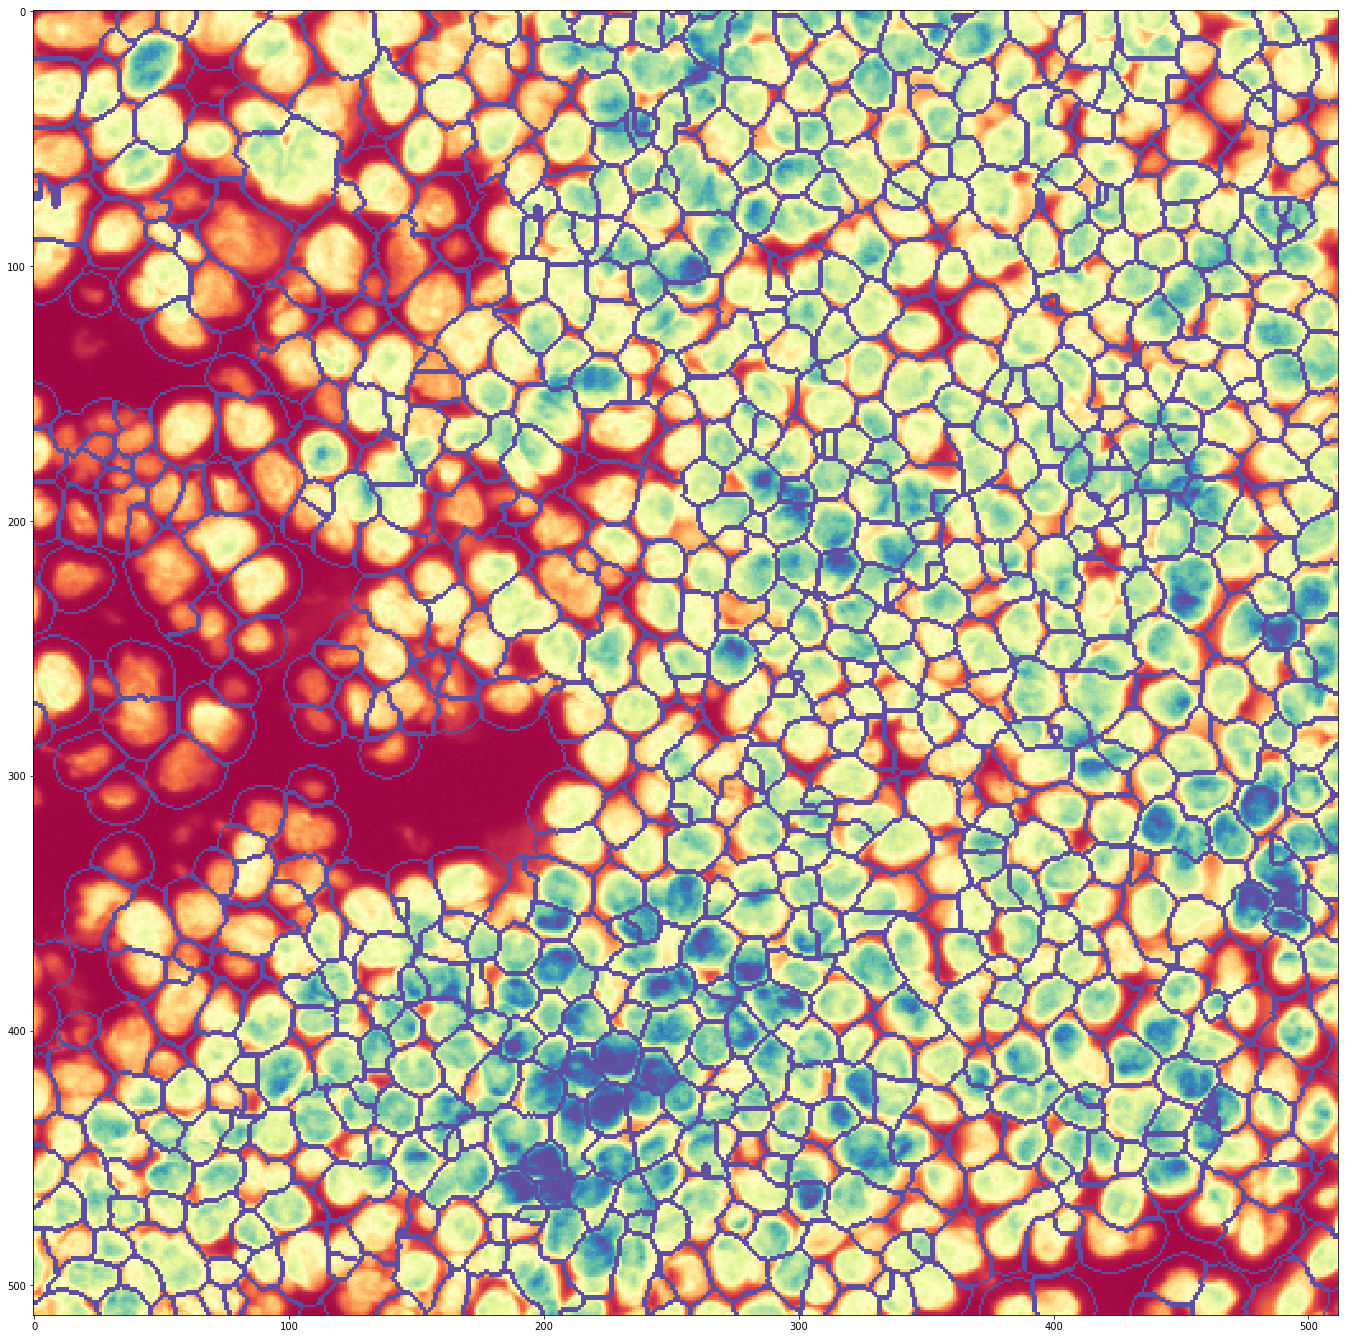

In [59]:
#crop = [slice(0, 256), slice(0, 256)]
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(0, None), slice(0, None)]
plt.imshow(img_nuc_border[crop], cmap='Spectral')
#plt.imshow(img_bin[crop].astype(float), cmap='Spectral')
plt.gcf().set_size_inches(24, 24)

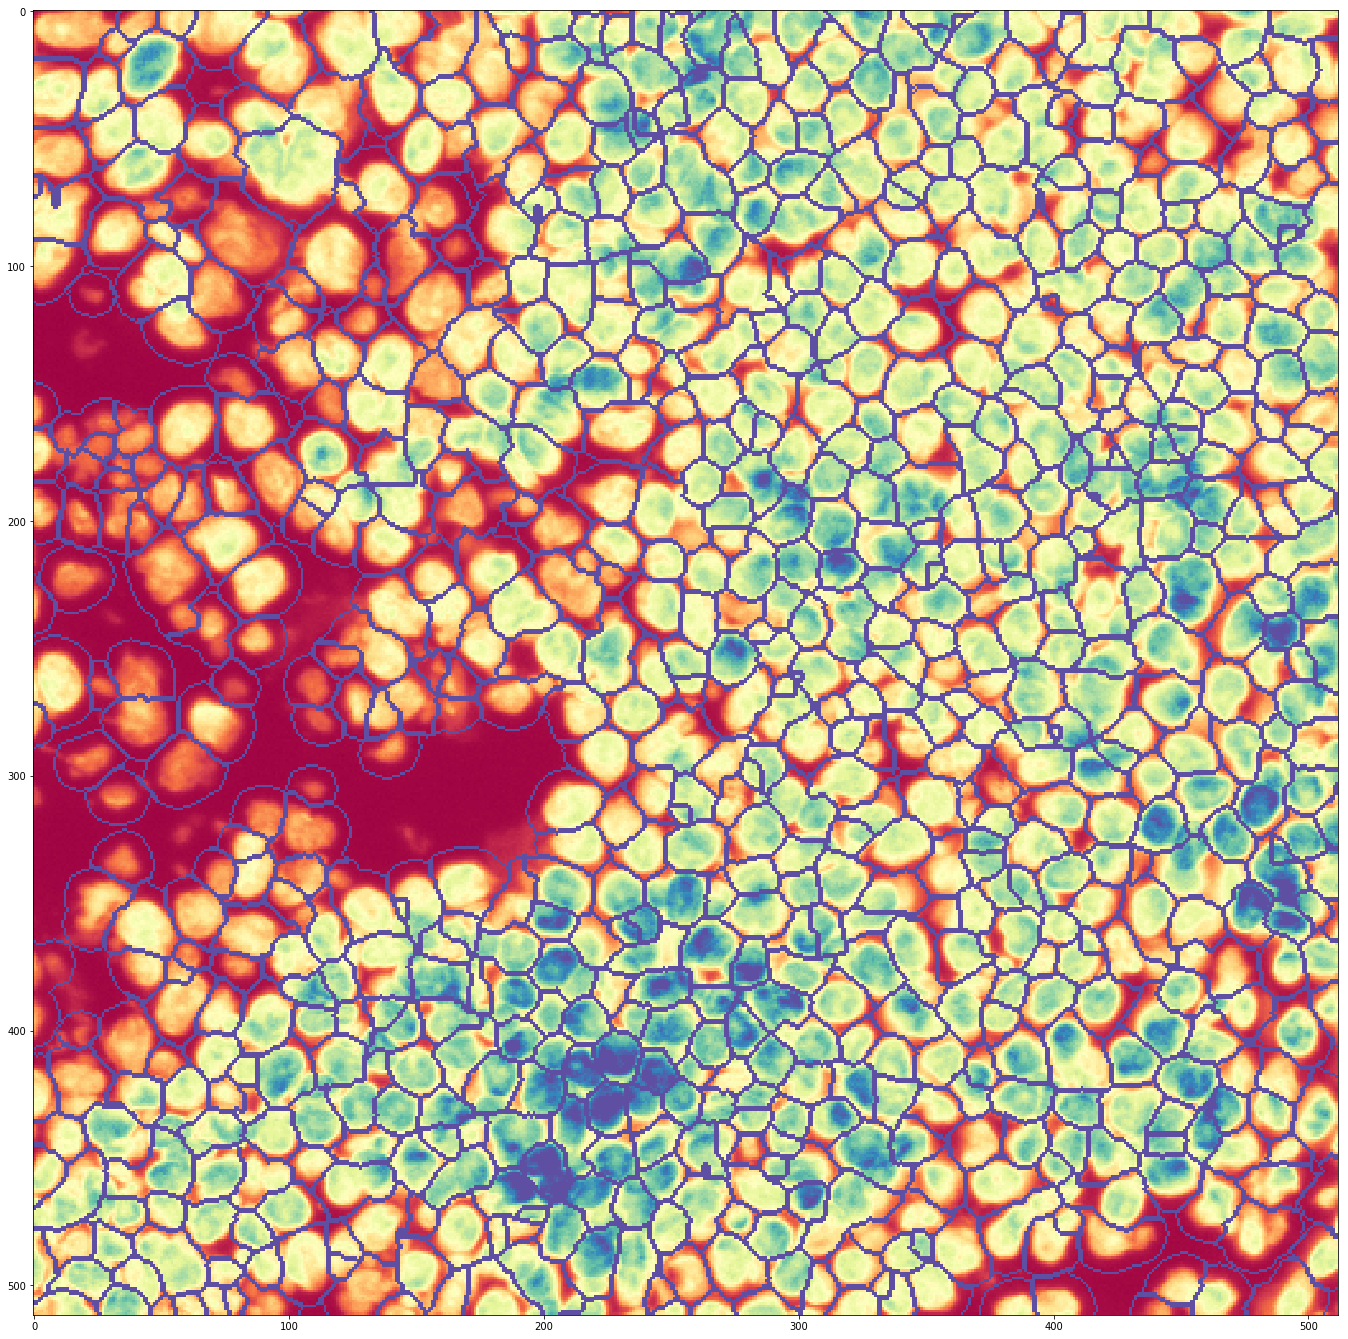

In [38]:
#crop = [slice(0, 256), slice(0, 256)]
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(0, None), slice(0, None)]
plt.imshow(img_nuc_border[crop], cmap='Spectral')
plt.gcf().set_size_inches(24, 24)

In [28]:
# %run models.py
# moments = {'mean': 22.95665170512068, 'std': 39.01833230843019}
# input_shape = img_nuc.shape[1:] + (1,)
# opt_conv = {"activation": "elu", "padding": "same", 'kernel_initializer': 'he_normal'}
# model = get_model(3, input_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None, opt_conv=opt_conv)